In [2]:
import numpy as np
import torch
import sys
sys.path.append("../Generic scripts")
import matplotlib.pyplot as plt
import matplotlib as mpl
import utils_kernels as KT 
import HS_utils as utils
import data_generator as generator

In [3]:
torch.set_default_dtype(torch.float64)
pt_path = "Experiments/tensors/"
fig_path = "Experiments/figures/"
csv_pat = "Experiments/tables/"

In [4]:
# Number of data points we will be using and basic parameters of the model
ndata = 80
# data generator : toy example of smola et al
mu_ex= generator.mu_ex
sigma_ex = generator.sigma_ex

eta_ex = lambda x : mu_ex(x)/sigma_ex(x)**2
la_ex = lambda x : 1/sigma_ex(x)**2

def gen(n = ndata):
    mu_ex= generator.mu_ex
    sigma_ex = generator.sigma_ex
    #sigma_ex = generator.sigma_aux(3)
    (x,y) = generator.generateData(mu_ex,sigma_ex,n,plot = False)
    return (x,y)

data_set = gen()
xdata_path = pt_path + 'xdataExperiments.pt'
ydata_path = pt_path + 'ydataExperiments.pt'

torch.save(data_set[0].view(ndata,1),xdata_path)
torch.save(data_set[1].view(ndata),ydata_path)


def data_split(data_set,r=0.5):
    x,y = data_set
    n = x.size(0)
    l = np.array(range(n))
    np.random.shuffle(l)
    x,y = x[l,:],y[l]
    ntr = int(np.ceil(n*r))
    nts = n - ntr
    data_set_train = x[:ntr,:],y[:ntr]
    data_set_test =x[ntr:,:],y[ntr:]
    return data_set_train,data_set_test



def LossHS(rx,ntest = ndata,data_set_test = None,eps=0):
    
    #Here eps is the moreau smoothing parameter
    if isinstance(data_set_test,type(None)):
        xtest,ytest = gen(n = ntest)
    else:
        xtest,ytest = data_set_test
        ntest = xtest.size(0)
    
    r = rx(xtest)
    if eps == 0:
        if (r[1]<=0).sum() > 0:
            return torch.tensor(np.inf)
        else:
            LL = utils.HSlossNW(ytest,eps).L
            L = lambda al : LL(al)/ntest
            rxe =  rx(xtest)
            rxe = [rxe[0].view(ntest,1),rxe[1].view(ntest,1)]
            return L(rxe)
            
    else:
        Leps = utils.HSlossNW(ytest,eps).Leps
        L = lambda al : Leps(al)/ntest
        rxe =  rx(xtest)
        rxe = [rxe[0].view(ntest,1),rxe[1].view(ntest,1)]
        return L(rxe)



# Experiments using basic linear model

In [4]:
def makerx(data_set,lae,lal,sigmae = 0.3,sigmal = 0.4,c=0,Niter = 100):
    x,y = data_set
    my = y.mean()
    yr = y-my
    
    
    LME = utils.LMK(sigmae,x,lae,kernel = 'gaussian',centered = False,c = c)
    LML = utils.LMK(sigmal,x,lal,kernel = 'gaussian',centered = False,c = c)
    
    lmodel = utils.HSLinearModel(LME,LML)
    model = utils.HSModel(lmodel,yr)
    
    freq = Niter//5
    #cb,cobj = model.cbcboj_pd(freq,plot= True)

    #al = model.prox_method(Niter,cb = cb,cobj = cobj)
    al = model.prox_method(Niter)
    
    def rx(x):
        rr = model.Rx_dual(al,x)
        eta = rr[0]
        la = rr[1]
        return [eta + my*la,la]
    return rx

## Finding the right parameters 

lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.2,sigmal = 0.2
ll = 1.5247869150721707
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.2,sigmal = 0.2
ll = 1.498206602142646
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.2,sigmal = 0.2
ll = 1.5441384370796147
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.2,sigmal = 0.2
ll = 1.5165515786520123
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.2,sigmal = 0.2
ll = 1.5991583948148083
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.2,sigmal = 0.2
ll = 1.6242208366136859
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.2,sigmal = 0.2
ll = 1.5664817853373882
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.2,sigmal = 0.3
ll = 1.7018936104053521
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.2,sigmal = 0.3
ll = 1.5982271574398164
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.2,sigmal = 0.3
ll = 1.5770267656742172
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.2,sigmal = 0.3
ll = 1.6500706415461135
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.2,sigmal = 0.3
ll = 1.5426029367066783
lambda_e = 0.1, l

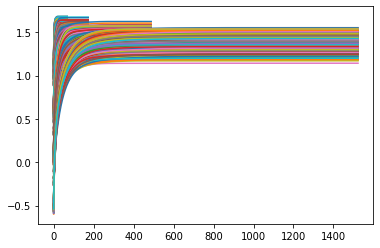

In [5]:
lae_l = [0.1,0.01,0.001,0.0001]
lal_l = [0.1,0.01,0.001,0.0001]
sigmae_l = [0.2,0.3,0.4,0.5]
sigmal_l = [0.2,0.3,0.4,0.5]

param_l = []
for lae in lae_l:
    for lal in lal_l:
        if lae/lal < 10.1 and lal/lae < 10.1:
            for sigmae in sigmae_l:
                for sigmal in sigmal_l:
                    param_l.append((lae,lal,sigmae,sigmal))
        

NN = len(param_l)

res = torch.zeros((6,NN))
res[2:,:] = torch.tensor(param_l).T

r = 0.7
K = 7

data_set = torch.load(xdata_path),torch.load(ydata_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        lae,lal,sigmae,sigmal = res[2,i],res[3,i],res[4,i],res[5,i]
        rx = makerx(data_set_train,lae,lal,sigmae = sigmae,sigmal = sigmal,Niter = 25 + 15*int(np.sqrt(1/min(lae,lal))))
        print('lambda_e = {}, lambda_l = {}, sigmae = {},sigmal = {}'.format(lae,lal,sigmae,sigmal))
        ll = LossHS(rx,data_set_test =data_set_test)
        print("ll = {}".format(ll))
        res[0,i] += ll
        res[1,i] += ll**2
    res[0,i]/= K
    res[1,i] /= K
    res[1,i] -= res[0,i]**2
    
    
    



In [16]:
#torch.save(res,pt_path + 'lambda_choice_linear1.pt')

lae
tensor([0.0010, 0.0010, 0.0100, 0.0010, 0.0010, 0.0100, 0.0001, 0.1000, 0.0010,
        0.1000, 0.0010, 0.0100, 0.0010, 0.0001, 0.0010, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0010, 0.0010, 0.0100, 0.0001, 0.0010, 0.1000, 0.0010, 0.0100,
        0.0100, 0.0010, 0.0100, 0.0010, 0.0100, 0.0010, 0.0010, 0.1000, 0.0001,
        0.0010, 0.0100, 0.0100, 0.0100, 0.0010, 0.0010, 0.0010, 0.0001, 0.0010,
        0.1000, 0.0100, 0.0100, 0.0100, 0.0010, 0.0100, 0.1000, 0.1000, 0.0100,
        0.0010, 0.0001, 0.1000, 0.0010, 0.0001, 0.0100, 0.0100, 0.1000, 0.0010,
        0.1000, 0.0100, 0.0001, 0.0100, 0.0010, 0.0010, 0.0001, 0.0001, 0.0100,
        0.0010, 0.0100, 0.0010, 0.0100, 0.0100, 0.0010, 0.0010, 0.1000, 0.1000,
        0.0010, 0.0100, 0.0001, 0.0001, 0.0010, 0.0010, 0.0100, 0.0100, 0.1000,
        0.0100, 0.0100, 0.0001, 0.1000, 0.1000, 0.0100, 0.0100, 0.1000, 0.1000,
        0.0010, 0.0010, 0.1000, 0.1000, 0.1000, 0.0001, 0.0100, 0.1000, 0.1000,
        0.1000, 0.0001, 0.0100, 0.01

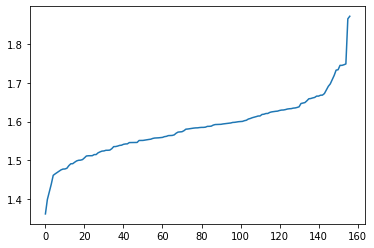

In [29]:
res_l = torch.load(pt_path +'lambda_choice_linear0.pt')
n = res_l.size(1)
_,i = torch.sort(res_l[0,:])
res_l = res_l[:,i]


print("lae")
print(res_l[2,:])
print("lal")
print(res_l[3,:])
print("sigmae")
print(res_l[4,:])
print("sigmal")
print(res_l[5,:])
print("result")
print(res_l[0,:])
print("ecart type")
print(torch.sqrt(res_l[1,:]))


plt.figure()
plt.plot(list(range(n)),res_l[0,:])
#plt.xlim(30,40)
plt.show()


In [8]:
sigmae,sigmal =0.3,0.4
M = (res_l[4,:] == sigmae)*(res_l[5,:] == sigmal)

In [18]:
sa = res_l[:,M]
print(sa[0,sa[3,:]==1e-1])

tensor([1.5845, 1.5514])


## Application to one case

tensor(1.)


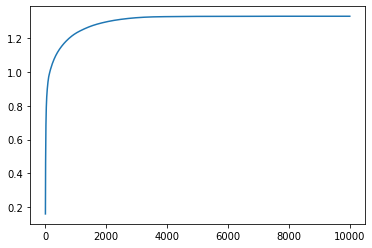

In [35]:
data_set = torch.load(xdata_path),torch.load(ydata_path)
lae = 0.001
lal = 0.0001
rx = makerx(data_set,lae,lal,sigmae = 0.3,sigmal=0.4,Niter= 10000)


In [ ]:
#plots

In [36]:
c,r,ntest = 0.5,0.5,100000
xtest = torch.linspace(c-r,c+r,ntest)
#c,r,ntest = 0,10,100000
#xtest = c + r*(2*torch.rand(ntest,d) - 1)
#xtest,_ = xtest.sort(dim=0)
rtest = rx(xtest)
eta = rtest[0]
la = rtest[1]
etat = eta_ex(xtest)
lat = la_ex(xtest)
#print(ytest.sum()*(2*r)**d/ntest)


torch.save(xtest,pt_path+'xtest_linear1.pt')
torch.save(eta,pt_path+'etatest_linear1.pt')
torch.save(la,pt_path+'latest_linear1.pt')
torch.save(etat,pt_path+'etatruth_linear1.pt')
torch.save(lat,pt_path+'latruth_linear1.pt')

torch.save(data_set[0],pt_path+'xdata_linear1.pt')
torch.save(data_set[1],pt_path+'ydata_linear1.pt')

#torch.save(xtest,pt_path+'xtest_linear0.pt')
#torch.save(ytest,pt_path+'ytest_linear0.pt')
#torch.save(ydata_set,pt_path+'ydata_linear0.pt')


etat = eta_ex(xtest)



/opt/miniconda3/envs/p36/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/opt/miniconda3/envs/p36/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/opt/miniconda3/envs/p36/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


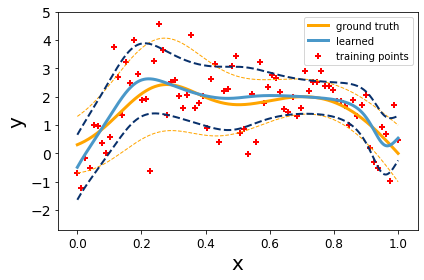

In [37]:
xtest = torch.load(pt_path+'xtest_linear1.pt')
eta = torch.load(pt_path+'etatest_linear1.pt')
la = torch.load(pt_path+'latest_linear1.pt')

etat = torch.load(pt_path+'etatruth_linear1.pt')
lat = torch.load(pt_path+'latruth_linear1.pt')

xdata = torch.load(pt_path+'xdata_linear1.pt')
ydata = torch.load(pt_path+'ydata_linear1.pt')

c = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])
lc = [4,6]

fig = plt.figure()

plt.plot(xtest,etat/lat,color = 'orange',lw = 3,label = 'ground truth')
plt.plot(xtest,etat/lat+torch.sqrt(1/lat),color = 'orange',linestyle ='dashed',lw = 1)
plt.plot(xtest,etat/lat-torch.sqrt(1/lat),color = 'orange',linestyle ='dashed',lw = 1)

plt.plot(xtest,eta/la,c=cmap.to_rgba(lc[0]),lw = 3,label = 'learned')
plt.plot(xtest,eta/la+torch.sqrt(1/la),c=cmap.to_rgba(lc[1]),linestyle ='dashed',lw = 2)
plt.plot(xtest,eta/la-torch.sqrt(1/la),c=cmap.to_rgba(lc[1]),linestyle ='dashed',lw = 2)



plt.scatter(xdata,ydata,marker = '+',color = 'r',lw = 2,label = 'training points')

plt.legend()
plt.ylim(-2.7,5)
plt.xlabel("x",fontsize = 20)
plt.ylabel("y",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
fig.savefig(fig_path+'linearPlot1hetero.pdf' , format='pdf', dpi=1000)
plt.show()


# Our model 

In [19]:
def makerx(data_set,lae,lal,sigmae = 0.3,sigmal = 0.4,c=0,Niter = 1000,show_plot = False):
    x,y = data_set
    my = y.mean()
    yr = y-my
    

    LME = utils.LMK(sigmae,x,lae,kernel = 'gaussian',centered = False,c = c)
    
    err = 0.01
    LML = utils.QKM(sigmal,x,lal*err,mu = lal,kernel = 'gaussian',centered = False,c = 0,positive = True)
    
    lmodel = utils.HSLinearModel(LME,LML)
    model = utils.HSModel(lmodel,yr)
    
    if show_plot:
        freq = Niter//5
        cb,cobj = model.cbcboj_pd(freq,plot= True)
        al = model.prox_method(Niter,cb = cb,cobj = cobj)
    else:
        al = model.prox_method(Niter)
    
    def rx(x):
        rr = model.Rx_dual(al,x)
        eta = rr[0]
        la = rr[1]
        return [eta + my*la,la]
    return rx

## Finding the right parameters 

In [ ]:
lae_l = [0.1,0.01,0.001,0.0001]
lal_l = [0.01,0.001,0.0001]
sigmae_l = [0.3,0.4]
sigmal_l = [0.3,0.4]

param_l = []
for lae in lae_l:
    for lal in lal_l:
        #if lae/lal < 10.1 and lal/lae < 10.1:
        if True:
            for sigmae in sigmae_l:
                for sigmal in sigmal_l:
                    param_l.append((lae,lal,sigmae,sigmal))
        

NN = len(param_l)

res = torch.zeros((6,NN))
res[2:,:] = torch.tensor(param_l).T

r = 0.7
K = 7

data_set = torch.load(xdata_path),torch.load(ydata_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        lae,lal,sigmae,sigmal = res[2,i],res[3,i],res[4,i],res[5,i]
        rx = makerx(data_set_train,lae,lal,sigmae = sigmae,sigmal = sigmal,Niter = 50 + 70*int(np.sqrt(1/min(lae,lal))))
        print('lambda_e = {}, lambda_l = {}, sigmae = {},sigmal = {}'.format(lae,lal,sigmae,sigmal))
        ll = LossHS(rx,data_set_test =data_set_test)
        print("ll = {}".format(ll))
        res[0,i] += ll
        res[1,i] += ll**2
    res[0,i]/= K
    res[1,i] /= K
    res[1,i] -= res[0,i]**2
    
    
 


tensor(1.)
lambda_e = 0.1, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.3
ll = 1.606055212059485
tensor(1.)
lambda_e = 0.1, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.3
ll = 1.452020936128081
tensor(1.)
lambda_e = 0.1, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.3
ll = 1.5201485272322444
tensor(1.)
lambda_e = 0.1, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.3
ll = 1.4747831616637594
tensor(1.)
lambda_e = 0.1, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.3
ll = 1.2263927172536284
tensor(1.)
lambda_e = 0.1, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.3
ll = 1.3117864672270036
tensor(1.)
lambda_e = 0.1, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.3
ll = 1.3893012867345176
tensor(1.)
lambda_e = 0.1, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.4
ll = 1.5950017341011078
tensor(1.)
lambda_e = 0.1, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.4
ll = 1.573928391567743
tensor(1.)
lambda_e = 0.1, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.4
ll = 1.608826401645664
tensor(1.)
lambda_e = 0.1, lambda_l = 0.01, sigmae = 0.3,sigmal 

In [26]:
#torch.save(res,pt_path + 'lambda_choice_ours0.pt')

lae
tensor([0.0001, 0.0010, 0.0001, 0.0010, 0.0001, 0.0100, 0.0001, 0.1000, 0.0010,
        0.0010, 0.0001, 0.0010, 0.0010, 0.0001, 0.0010, 0.0100, 0.0001, 0.1000,
        0.0100, 0.0100, 0.0100, 0.0001, 0.0010, 0.0100, 0.0100, 0.0001, 0.0100,
        0.0010, 0.1000, 0.0100, 0.0010, 0.0010, 0.0001, 0.1000, 0.1000, 0.0010,
        0.1000, 0.1000, 0.0001, 0.0100, 0.0100, 0.0100, 0.1000, 0.1000, 0.0001,
        0.1000, 0.1000, 0.1000])
lal
tensor([0.0100, 0.0010, 0.0010, 0.0100, 0.0100, 0.0100, 0.0001, 0.0100, 0.0010,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0010, 0.0100, 0.0010, 0.0100, 0.0001,
        0.0100, 0.0100, 0.0100, 0.0001, 0.0001, 0.0010, 0.0001, 0.0001, 0.0010,
        0.0010, 0.0100, 0.0010, 0.0100, 0.0100, 0.0100, 0.0010, 0.0001, 0.0010,
        0.0100, 0.0001, 0.0010, 0.0001, 0.0001, 0.0001, 0.0100, 0.0001, 0.0010,
        0.0010, 0.0010, 0.0010])
sigmae
tensor([0.4000, 0.4000, 0.4000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
        0.3000, 0.4000, 0.4000, 0.4000,

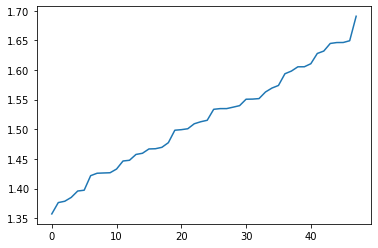

In [27]:
res_l = torch.load(pt_path +'lambda_choice_ours0.pt')
n = res_l.size(1)

_,i = torch.sort(res_l[0,:])
res_l = res_l[:,i]

print("lae")
print(res_l[2,:])
print("lal")
print(res_l[3,:])
print("sigmae")
print(res_l[4,:])
print("sigmal")
print(res_l[5,:])
print("result")
print(res_l[0,:])
print("variance")
print(res_l[1,:])

plt.figure()
plt.plot(list(range(n)),res_l[0,:])

plt.show()

## Trying the method 

tensor(1.)


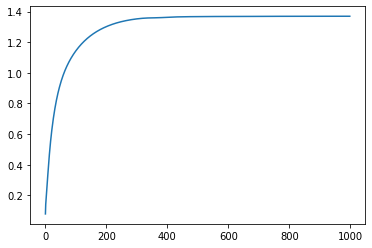

In [30]:
data_set = torch.load(xdata_path),torch.load(ydata_path)
lae = 0.0001
lal = 0.01
rx = makerx(data_set,lae,lal,sigmae = 0.4,sigmal=0.3,Niter= 1000)



In [31]:
#Plots

c,r,ntest = 0.5,0.5,1000
xtest = torch.linspace(c-r,c+r,ntest)
#c,r,ntest = 0,10,100000
#xtest = c + r*(2*torch.rand(ntest,d) - 1)
#xtest,_ = xtest.sort(dim=0)
rtest = rx(xtest)
eta = rtest[0]
la = rtest[1]
etat = eta_ex(xtest)
lat = la_ex(xtest)
#print(ytest.sum()*(2*r)**d/ntest)


torch.save(xtest,pt_path+'xtest_ours1.pt')
torch.save(eta,pt_path+'etatest_ours1.pt')
torch.save(la,pt_path+'latest_ours1.pt')
torch.save(etat,pt_path+'etatruth_ours1.pt')
torch.save(lat,pt_path+'latruth_ours1.pt')

torch.save(data_set[0],pt_path+'xdata_ours1.pt')
torch.save(data_set[1],pt_path+'ydata_ours1.pt')

#torch.save(xtest,pt_path+'xtest_linear0.pt')
#torch.save(ytest,pt_path+'ytest_linear0.pt')
#torch.save(ydata_set,pt_path+'ydata_linear0.pt')


etat = eta_ex(xtest)




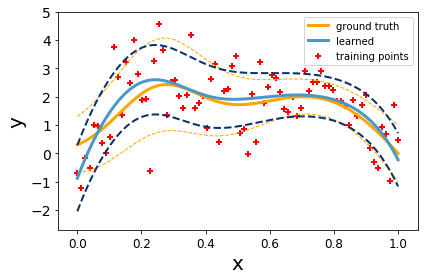

In [32]:
xtest = torch.load(pt_path+'xtest_ours1.pt')
eta = torch.load(pt_path+'etatest_ours1.pt')
la = torch.load(pt_path+'latest_ours1.pt')

etat = torch.load(pt_path+'etatruth_ours1.pt')
lat = torch.load(pt_path+'latruth_ours1.pt')

xdata = torch.load(pt_path+'xdata_ours1.pt')
ydata = torch.load(pt_path+'ydata_ours1.pt')

c = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])
lc = [4,6]

fig = plt.figure()

plt.plot(xtest,etat/lat,color = 'orange',lw = 3,label = 'ground truth')
plt.plot(xtest,etat/lat+torch.sqrt(1/lat),color = 'orange',linestyle ='dashed',lw = 1)
plt.plot(xtest,etat/lat-torch.sqrt(1/lat),color = 'orange',linestyle ='dashed',lw = 1)

plt.plot(xtest,eta/la,c=cmap.to_rgba(lc[0]),lw = 3,label = 'learned')
plt.plot(xtest,eta/la+torch.sqrt(1/la),c=cmap.to_rgba(lc[1]),linestyle ='dashed',lw = 2)
plt.plot(xtest,eta/la-torch.sqrt(1/la),c=cmap.to_rgba(lc[1]),linestyle ='dashed',lw = 2)



plt.scatter(xdata,ydata,marker = '+',color = 'r',lw = 2,label = 'training points')

plt.legend()
plt.ylim(-2.7,5)
plt.xlabel("x",fontsize = 20)
plt.ylabel("y",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
fig.savefig(fig_path+'oursPlot1hetero.pdf' , format='pdf', dpi=1000)
plt.show()

# Nadaraya Watson stuff

In [40]:
def makerx(data_set,lae,lal,sigmae = 0.1,sigmal = 0.1,c=0,Niter = 50,show_plot = False):
    x,y = data_set
    my = y.mean()
    yr = y-my
    
    eps = 0.01
    
    
    LME = utils.kernelModel(sigmae,x,kernel = 'gaussian',centered = False,c=c)
    LML = utils.kernelModel(sigmal,x,kernel = 'gaussian',positive = True,c=c)
    model = utils.HSLinearModelNW(LME,LML)
    
    hsm = utils.HSModelNW(model,lae,lal,yr,eps)
    
    al = hsm.FISTA(Niter)
    
    def rx(x):
        rr = model.Rx(al,x)
        eta = rr[0]
        la = rr[1]
        return [eta + my*la,la]
    return rx

# Finding the right parameters

lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.3,sigmal = 0.1
ll = 1.5421649661208017
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.3,sigmal = 0.1
ll = 1.6834697141772714
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.3,sigmal = 0.1
ll = 1.462915501351307
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.3,sigmal = 0.1
ll = 1.4748955838550064
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.3,sigmal = 0.1
ll = 1.4874218198963385
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.3,sigmal = 0.1
ll = 1.6840653417996607
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.3,sigmal = 0.1
ll = 1.6628732905292496
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.3,sigmal = 0.2
ll = 1.5325772169503127
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.3,sigmal = 0.2
ll = 1.6318584055518022
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.3,sigmal = 0.2
ll = 1.3417058083859186
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.3,sigmal = 0.2
ll = 1.5785427793670699
lambda_e = 0.1, lambda_l = 0.1, sigmae = 0.3,sigmal = 0.2
ll = 1.546773809187153
lambda_e = 0.1, la

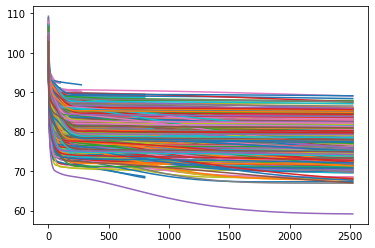

In [41]:
lae_l = [0.1,0.01,0.001,0.0001]
lal_l = [0.1,0.01,0.001,0.0001]
sigmae_l = [0.3,0.4]
sigmal_l = [0.1,0.2,0.3,0.4]

param_l = []
for lae in lae_l:
    for lal in lal_l:
        if True:
        #if lae/lal < 10.1 and lal/lae < 10.1:
            for sigmae in sigmae_l:
                for sigmal in sigmal_l:
                    param_l.append((lae,lal,sigmae,sigmal))
        

NN = len(param_l)

res = torch.zeros((6,NN))
res[2:,:] = torch.tensor(param_l).T

r = 0.7
K = 7

data_set = torch.load(xdata_path),torch.load(ydata_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        lae,lal,sigmae,sigmal = res[2,i],res[3,i],res[4,i],res[5,i]
        rx = makerx(data_set_train,lae,lal,sigmae = sigmae,sigmal = sigmal,Niter = 25 + 25*int(np.sqrt(1/min(lae,lal))))
        print('lambda_e = {}, lambda_l = {}, sigmae = {},sigmal = {}'.format(lae,lal,sigmae,sigmal))
        ll = LossHS(rx,data_set_test =data_set_test)
        print("ll = {}".format(ll))
        res[0,i] += ll
        res[1,i] += ll**2
    res[0,i]/= K
    res[1,i] /= K
    res[1,i] -= res[0,i]**2
    
    

In [42]:

#torch.save(res,pt_path+'lambda_choice_NW0.pt')

lae
tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0010, 0.0100, 0.0100, 0.0001, 0.1000,
        0.0010, 0.0001, 0.0100, 0.0001, 0.1000, 0.0010, 0.0100, 0.1000, 0.0001,
        0.0100, 0.0010, 0.0010, 0.0001, 0.0001, 0.0010, 0.0001, 0.0010, 0.0100,
        0.1000, 0.1000, 0.0001, 0.0010, 0.0100, 0.1000, 0.0100, 0.0001, 0.0010,
        0.0001, 0.0100, 0.0001, 0.0001, 0.0001, 0.0100, 0.1000, 0.0010, 0.0100,
        0.0001, 0.0100, 0.0001, 0.0001, 0.0100, 0.0100, 0.0010, 0.1000, 0.0010,
        0.0001, 0.1000, 0.0010, 0.0010, 0.0001, 0.0010, 0.0001, 0.1000, 0.0100,
        0.0100, 0.0001, 0.0010, 0.0100, 0.0010, 0.0100, 0.1000, 0.1000, 0.0010,
        0.1000, 0.1000, 0.0010, 0.0001, 0.0010, 0.0010, 0.0100, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.0100, 0.0100, 0.0100, 0.1000, 0.1000, 0.0010,
        0.0001, 0.0100, 0.0010, 0.1000, 0.0100, 0.1000, 0.0001, 0.0100, 0.1000,
        0.0010, 0.1000, 0.1000, 0.0100, 0.1000, 0.1000, 0.0100, 0.0100, 0.1000,
        0.0001, 0.0100, 0.0010, 0.01

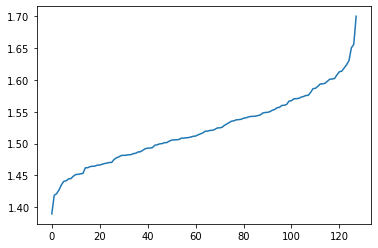

In [43]:
res_l = torch.load(pt_path +'lambda_choice_NW0.pt')
n = res_l.size(1)

_,i = torch.sort(res_l[0,:])
res_l = res_l[:,i]

print("lae")
print(res_l[2,:])
print("lal")
print(res_l[3,:])
print("sigmae")
print(res_l[4,:])
print("sigmal")
print(res_l[5,:])
print("result")
print(res_l[0,:])
print("variance")
print(res_l[1,:])

plt.figure()
plt.plot(list(range(n)),res_l[0,:])

plt.show()

## Trying the method 

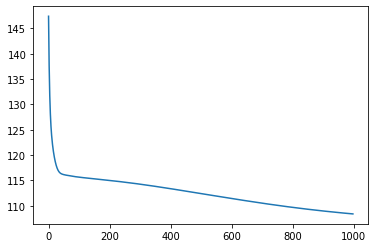

In [44]:
data_set = torch.load(xdata_path),torch.load(ydata_path)
lae = 0.0001
lal = 0.01
rx = makerx(data_set,lae,lal,sigmae = 0.3,sigmal=0.1,Niter= 1000)





In [45]:
#Plots

c,r,ntest = 0.5,0.5,1000
xtest = torch.linspace(c-r,c+r,ntest)
#c,r,ntest = 0,10,100000
#xtest = c + r*(2*torch.rand(ntest,d) - 1)
#xtest,_ = xtest.sort(dim=0)
rtest = rx(xtest)
eta = rtest[0]
la = rtest[1]
etat = eta_ex(xtest)
lat = la_ex(xtest)
#print(ytest.sum()*(2*r)**d/ntest)


torch.save(xtest,pt_path+'xtest_NW1.pt')
torch.save(eta,pt_path+'etatest_NW1.pt')
torch.save(la,pt_path+'latest_NW1.pt')
torch.save(etat,pt_path+'etatruth_NW1.pt')
torch.save(lat,pt_path+'latruth_NW1.pt')

torch.save(data_set[0],pt_path+'xdata_NW1.pt')
torch.save(data_set[1],pt_path+'ydata_NW1.pt')



etat = eta_ex(xtest)

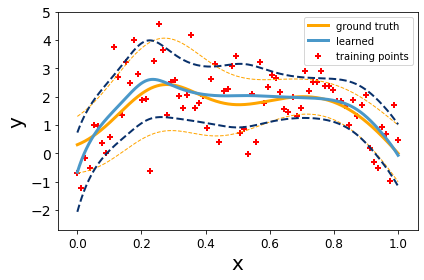

In [46]:
xtest = torch.load(pt_path+'xtest_NW1.pt')
eta = torch.load(pt_path+'etatest_NW1.pt')
la = torch.load(pt_path+'latest_NW1.pt')

etat = torch.load(pt_path+'etatruth_NW1.pt')
lat = torch.load(pt_path+'latruth_NW1.pt')

xdata = torch.load(pt_path+'xdata_NW1.pt')
ydata = torch.load(pt_path+'ydata_NW1.pt')

c = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])
lc = [4,6]

fig = plt.figure()

plt.plot(xtest,etat/lat,color = 'orange',lw = 3,label = 'ground truth')
plt.plot(xtest,etat/lat+torch.sqrt(1/lat),color = 'orange',linestyle ='dashed',lw = 1)
plt.plot(xtest,etat/lat-torch.sqrt(1/lat),color = 'orange',linestyle ='dashed',lw = 1)

plt.plot(xtest,eta/la,c=cmap.to_rgba(lc[0]),lw = 3,label = 'learned')
plt.plot(xtest,eta/la+torch.sqrt(1/la),c=cmap.to_rgba(lc[1]),linestyle ='dashed',lw = 2)
plt.plot(xtest,eta/la-torch.sqrt(1/la),c=cmap.to_rgba(lc[1]),linestyle ='dashed',lw = 2)



plt.scatter(xdata,ydata,marker = '+',color = 'r',lw = 2,label = 'training points')

plt.legend()
plt.ylim(-2.7,5)
plt.xlabel("x",fontsize = 20)
plt.ylabel("y",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
fig.savefig(fig_path+'oursPlot1hetero.pdf' , format='pdf', dpi=1000)
plt.show()

# GLM

In [47]:
def makerx(data_set,lae,lal,sigmae = 0.3,sigmal = 0.4,c=0,Niter =10,show_plot = False):
    x,y = data_set
    my = y.mean()
    yr = y-my
    
    eps = 0.01
    loss = utils.HSlossNW(yr,eps)
    
    
    LME = utils.kernelExpoModel(sigmae,x,kernel = 'gaussian',c=c,centered = False,positive = False)
    LML = utils.kernelExpoModel(sigmal,x,kernel = 'gaussian',c=c,positive = True)
    model = utils.HSLinearModelExpo(LME,LML)
    
    hsm = utils.HSModelExpo(model,lae,lal,yr,eps)
    
    al = hsm.GDr(Niter,Nrestarts=2,acceleration = True,eps = 0.2)
    
    def rx(x):
        rr = model.px(al,x)
        eta = rr[0]
        la = rr[1]
        return [eta + my*la,la]
    return rx

FInding $\lambda$

lambda_e = 0.001, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.2
ll = 1.311783269133821
lambda_e = 0.001, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.2
ll = 1.3459081751894004
lambda_e = 0.001, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.2
ll = 1.6273813021059942
lambda_e = 0.001, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.2
ll = 1.3741918596897804
lambda_e = 0.001, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.2
ll = 1.4235748871681306
lambda_e = 0.001, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.2
ll = 1.4417128501079268
lambda_e = 0.001, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.2
ll = 1.5618944044508989
lambda_e = 0.001, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.3
ll = 1.3553774867197428
lambda_e = 0.001, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.3
ll = 1.8697646774396308
lambda_e = 0.001, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.3
ll = 1.7462220371756072
lambda_e = 0.001, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.3
ll = 1.3111088447546149
lambda_e = 0.001, lambda_l = 0.01, sigmae = 0.3,sigmal = 0.3
ll = 

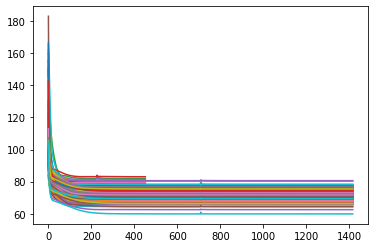

In [48]:
lae_l = [0.001,0.0001]
lal_l = [0.01,0.001,0.0001]
sigmae_l = [0.3,0.4]
sigmal_l = [0.2,0.3,0.4]

param_l = []
for lae in lae_l:
    for lal in lal_l:
        if lae/lal < 10.1 and lal/lae < 10.1:
            for sigmae in sigmae_l:
                for sigmal in sigmal_l:
                    param_l.append((lae,lal,sigmae,sigmal))
        

NN = len(param_l)

res = torch.zeros((6,NN))
res[2:,:] = torch.tensor(param_l).T

r = 0.7
K = 7

data_set = torch.load(xdata_path),torch.load(ydata_path)
for i in range(NN):
    for k in range(K):
        data_set_train,data_set_test = data_split(data_set,r=r)
        lae,lal,sigmae,sigmal = res[2,i],res[3,i],res[4,i],res[5,i]
        rx = makerx(data_set_train,lae,lal,sigmae = sigmae,sigmal = sigmal,Niter = 10 + 7*int(np.sqrt(1/min(lae,lal))))
        print('lambda_e = {}, lambda_l = {}, sigmae = {},sigmal = {}'.format(lae,lal,sigmae,sigmal))
        ll = LossHS(rx,data_set_test =data_set_test)
        print("ll = {}".format(ll))
        res[0,i] += ll
        res[1,i] += ll**2
    res[0,i]/= K
    res[1,i] /= K
    res[1,i] -= res[0,i]**2
    

In [49]:

#torch.save(res,pt_path+'lambda_choice_GLM0.pt')

lae
tensor([0.0001, 0.0010, 0.0010, 0.0010, 0.0001, 0.0010, 0.0010, 0.0010, 0.0001,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0001, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0001, 0.0010, 0.0010, 0.0001, 0.0010, 0.0001, 0.0010, 0.0001, 0.0001,
        0.0001, 0.0001, 0.0001])
lal
tensor([0.0001, 0.0100, 0.0010, 0.0010, 0.0010, 0.0100, 0.0010, 0.0010, 0.0010,
        0.0001, 0.0001, 0.0010, 0.0001, 0.0010, 0.0100, 0.0100, 0.0100, 0.0010,
        0.0001, 0.0001, 0.0100, 0.0001, 0.0001, 0.0001, 0.0001, 0.0010, 0.0001,
        0.0010, 0.0010, 0.0001])
sigmae
tensor([0.3000, 0.4000, 0.3000, 0.3000, 0.3000, 0.3000, 0.4000, 0.3000, 0.4000,
        0.3000, 0.3000, 0.4000, 0.4000, 0.4000, 0.3000, 0.4000, 0.4000, 0.4000,
        0.3000, 0.4000, 0.3000, 0.4000, 0.3000, 0.4000, 0.4000, 0.3000, 0.3000,
        0.4000, 0.3000, 0.4000])
sigmal
tensor([0.3000, 0.3000, 0.2000, 0.4000, 0.4000, 0.2000, 0.4000, 0.3000, 0.4000,
        0.4000, 0.3000, 0.3000, 0.4000, 0.2000, 0.3000, 0.2000, 0.4000, 0.2000,

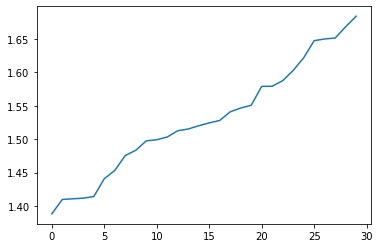

In [50]:
res_l = torch.load(pt_path +'lambda_choice_GLM0.pt')
n = res_l.size(1)

_,i = torch.sort(res_l[0,:])
res_l = res_l[:,i]

print("lae")
print(res_l[2,:])
print("lal")
print(res_l[3,:])
print("sigmae")
print(res_l[4,:])
print("sigmal")
print(res_l[5,:])
print("result")
print(res_l[0,:])
print("variance")
print(res_l[1,:])

plt.figure()
plt.plot(list(range(n)),res_l[0,:])

plt.show()

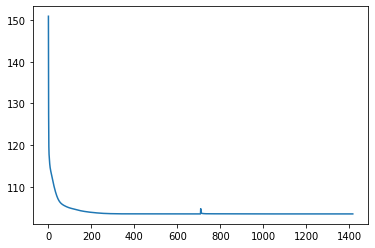

In [51]:
data_set = torch.load(xdata_path),torch.load(ydata_path)
lae = 0.0001
lal = 0.0001
rx = makerx(data_set,lae,lal,sigmae = 0.3,sigmal=0.3,Niter= 10 + 7*int(np.sqrt(1/min(lae,lal))))




In [52]:
#Plots

c,r,ntest = 0.5,0.5,1000
xtest = torch.linspace(c-r,c+r,ntest)
#c,r,ntest = 0,10,100000
#xtest = c + r*(2*torch.rand(ntest,d) - 1)
#xtest,_ = xtest.sort(dim=0)
rtest = rx(xtest)
eta = rtest[0]
la = rtest[1]
etat = eta_ex(xtest)
lat = la_ex(xtest)
#print(ytest.sum()*(2*r)**d/ntest)


torch.save(xtest,pt_path+'xtest_GLM1.pt')
torch.save(eta,pt_path+'etatest_GLM1.pt')
torch.save(la,pt_path+'latest_GLM1.pt')
torch.save(etat,pt_path+'etatruth_GLM1.pt')
torch.save(lat,pt_path+'latruth_GLM1.pt')

torch.save(data_set[0],pt_path+'xdata_GLM1.pt')
torch.save(data_set[1],pt_path+'ydata_GLM1.pt')



etat = eta_ex(xtest)

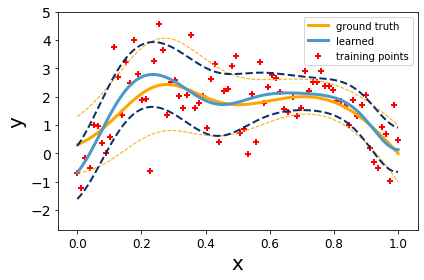

In [53]:
xtest = torch.load(pt_path+'xtest_GLM1.pt')
eta = torch.load(pt_path+'etatest_GLM1.pt')
la = torch.load(pt_path+'latest_GLM1.pt')

etat = torch.load(pt_path+'etatruth_GLM1.pt')
lat = torch.load(pt_path+'latruth_GLM1.pt')

xdata = torch.load(pt_path+'xdata_GLM1.pt')
ydata = torch.load(pt_path+'ydata_GLM1.pt')

c = np.arange(1, 7)
norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap.set_array([])
lc = [4,6]

fig = plt.figure()

plt.plot(xtest,etat/lat,color = 'orange',lw = 3,label = 'ground truth')
plt.plot(xtest,etat/lat+torch.sqrt(1/lat),color = 'orange',linestyle ='dashed',lw = 1)
plt.plot(xtest,etat/lat-torch.sqrt(1/lat),color = 'orange',linestyle ='dashed',lw = 1)

plt.plot(xtest,eta/la,c=cmap.to_rgba(lc[0]),lw = 3,label = 'learned')
plt.plot(xtest,eta/la+torch.sqrt(1/la),c=cmap.to_rgba(lc[1]),linestyle ='dashed',lw = 2)
plt.plot(xtest,eta/la-torch.sqrt(1/la),c=cmap.to_rgba(lc[1]),linestyle ='dashed',lw = 2)



plt.scatter(xdata,ydata,marker = '+',color = 'r',lw = 2,label = 'training points')

plt.legend()
plt.ylim(-2.7,5)
plt.xlabel("x",fontsize = 20)
plt.ylabel("y",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.tight_layout()
fig.savefig(fig_path+'GLMPlot1hetero.pdf' , format='pdf', dpi=1000)
plt.show()

In [1]:
import torch

In [6]:
torch.randint(2,(10,))

tensor([1, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [24]:
np = 10
d = 2
mask = torch.randint(2,(np,))
mask = mask.unsqueeze(1).expand((np,d))
print(mask)

tensor([[1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0],
        [1, 1],
        [0, 0]])


In [25]:
x = 2*torch.rand((10,2))-1
#self.nu = lambda x : (1 - ((x - mu_base.unsqueeze(0)) > sigma_base).sum().double().clamp(max=0.5) - ((x - mu_base.unsqueeze(0)) < -sigma_base).sum().double().clamp(max=0.5))/volume

In [26]:
print(x)
mu_base= torch.zeros((2,))
sigma_base = 0.5

tensor([[ 0.2045,  0.6963],
        [-0.0559,  0.6861],
        [ 0.4397,  0.4107],
        [-0.8651,  0.3398],
        [ 0.5074,  0.3672],
        [ 0.9623, -0.8055],
        [ 0.1284,  0.1720],
        [ 0.2747, -0.0465],
        [-0.0181, -0.1130],
        [ 0.2097, -0.7484]])


In [27]:
nu = lambda x : (1 - ((x - mu_base.unsqueeze(0)) > sigma_base).sum(1).double() - ((x - mu_base.unsqueeze(0)) < -sigma_base).sum(1).double()).clamp(min=0)

In [28]:
nu(x)

tensor([0., 0., 1., 0., 0., 0., 1., 1., 1., 0.], dtype=torch.float64)